# Captsone project : Eye for Blind By Rucha Tare
This notebook will be used to prepare the capstone project 'Eye for Blind'

## STEP 1 : Import all relevant libraries

In [ ]:
#Import all the required libraries
import glob
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

from PIL import Image
from PIL import ImageFont
from PIL import ImageDraw 
from pickle import dump,load
from tqdm import tqdm
from collections import Counter

import keras
from keras.models import Sequential
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.optimizers import Adam, RMSprop
from keras.layers.wrappers import Bidirectional
from keras.layers.merge import add
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from nltk.corpus import stopwords
from nltk.translate.bleu_score import sentence_bleu

import tensorflow as tf
from tensorflow.keras import Input, layers
from tensorflow.keras import optimizers
from tensorflow.keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector,\
                         Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization, Conv2D

import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_colwidth', 100)

## STEP 2 : Data understanding
1.Import the dataset and read image & captions into two seperate variables

2.Visualise both the images & text present in the dataset

3.Create a dataframe which summarizes the image, path & captions as a dataframe

4.Create a list which contains all the captions & path

5.Visualise the top 30 occuring words in the captions



### 2.1 : Data sourcing 

In [ ]:
DATA_DIR = "data"
IMAGES_DIR = os.path.join(DATA_DIR,'Images')
CAPTIONS_FILE = os.path.join(DATA_DIR,'captions.txt')
OUTPUT_IMAGE_PATH = "../working/Image/"

In [ ]:
#Import the dataset and read the image into a seperate variable

all_imgs = glob.glob(IMAGES_DIR + '/*.jpg',recursive=True)
print("The total images present in the dataset: {}".format(len(all_imgs)))

The total images present in the dataset: 8091


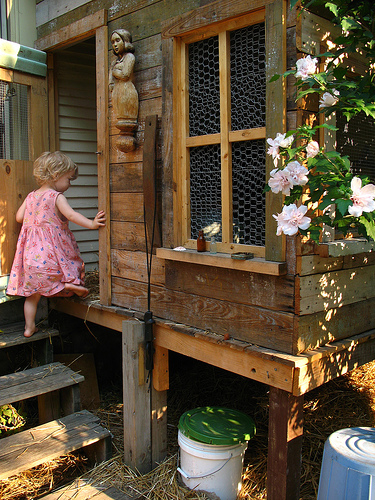

In [ ]:
#Visualise both the images & text present in the dataset
Image.open(all_imgs[0])

In [ ]:
#Import the dataset and read the text file into a seperate variable

def load_doc(filename):
    
    text=open(filename).read()    
    return text

doc = load_doc(CAPTIONS_FILE)
print(doc[:300])

image,caption
1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg,A girl going into a wooden building .
1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg,A little girl climbing


### 2.2 : Create a dataframe which summarizes the image, path & captions as a dataframe

Each image id has 5 captions associated with it therefore the total dataset should have 40455 samples.

In [ ]:
def get_img_ids_and_captions(text):
    keys=[]
    values=[]
    key_paths=[]
    text=text.splitlines()[1:]

    for line in text:
        com_idx=line.index(",")
        im_id,im_cap=line[:com_idx], line[com_idx+1:]
        keys.append(im_id)
        values.append(im_cap)
        key_paths.append(IMAGES_DIR +'/'+ im_id)

    return keys, values, key_paths

In [ ]:
all_img_id,annotations,all_img_vector = get_img_ids_and_captions(doc)#store all the image id here

df = pd.DataFrame(list(zip(all_img_id, all_img_vector,annotations)),columns =['ID', 'Path', 'Captions']) 
    
df.head(5)

,ID,Path,Captions
0,1000268201_693b08cb0e.jpg,data\Images/1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .
1,1000268201_693b08cb0e.jpg,data\Images/1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,data\Images/1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,data\Images/1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playhouse .
4,1000268201_693b08cb0e.jpg,data\Images/1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a wooden cabin .


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40455 entries, 0 to 40454
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   ID        40455 non-null  object
 1   Path      40455 non-null  object
 2   Captions  40455 non-null  object
dtypes: object(3)
memory usage: 948.3+ KB


### 2.3 : Create a list of captions

In [ ]:
#Create a list which contains all the captions
annotations = df.Captions.apply(lambda x:'<start> '+ x + ' <end>').to_list()

#Create a list which contains all the path to the images
all_img_path = df.Path.to_list()#write your code here

print("Total captions present in the dataset: "+ str(len(annotations)))
print("Total images present in the dataset: " + str(len(all_img_path)))

Total captions present in the dataset: 40455
Total images present in the dataset: 40455


### 2.4 : Create the vocabulary & the counter for the captions

In [ ]:
#Create the vocabulary & the counter for the captions

def voc_fetcher(frame,column):
    out=[]
    for i in frame[column]:
        out+=i.split(" ")
    return out


vocabulary=voc_fetcher(df,"Captions")
val_count=Counter(vocabulary)

print(f"Size of Vocab : {len(set(vocabulary))}")
val_count


Size of Vocab : 9862


Counter({'A': 21481,
         'child': 1477,
         'in': 18961,
         'a': 40271,
         'pink': 734,
         'dress': 347,
         'is': 9345,
         'climbing': 502,
         'up': 1260,
         'set': 108,
         'of': 6712,
         'stairs': 109,
         'an': 1944,
         'entry': 1,
         'way': 50,
         '.': 34212,
         'girl': 3217,
         'going': 149,
         'into': 1074,
         'wooden': 284,
         'building': 509,
         'little': 1625,
         'playhouse': 6,
         'the': 15328,
         'to': 3173,
         'her': 1178,
         'cabin': 4,
         'black': 3696,
         'dog': 7982,
         'and': 8850,
         'spotted': 37,
         'are': 3503,
         'fighting': 132,
         'tri-colored': 14,
         'playing': 2008,
         'with': 7760,
         'each': 430,
         'other': 771,
         'on': 10729,
         'road': 388,
         'white': 3875,
         'brown': 2475,
         'spots': 29,
         'staring'

### 2.5 : Visualize the top 30 words 

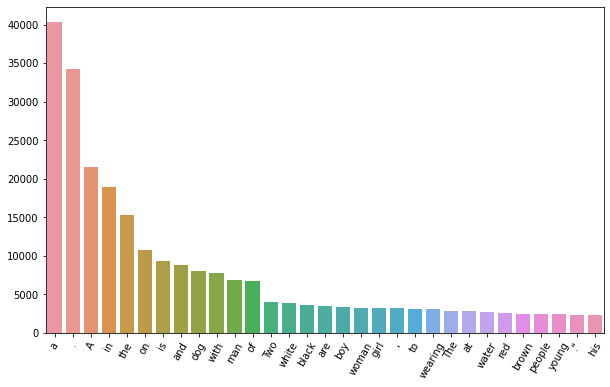

In [ ]:
# Visualise the top 30 occuring words in the captions
def get_top_words_based_on_cnt(words_dict,n_words):
    n_words+=1
    keys=list(words_dict.keys())
    values=list(words_dict.values())
    sorted_values=sorted(values,reverse=True)[:n_words]
    sorted_keys=[]
    for i in sorted_values:
        if sorted_values.count(i)==1:
            sorted_keys.append(keys[values.index(i)])
        elif sorted_values.count(i)==2:
            f_idx=values.index(i)
            s_idx=values[f_idx+1:].index(i)
            s_idx+=f_idx+1
            a,b=keys[f_idx],keys[s_idx]
            if a not in sorted_keys and b not in sorted_keys:
                sorted_keys.append(a)
                sorted_keys.append(b)
    plt.figure(figsize=(10,6))
    sns.barplot(x=sorted_keys,y=sorted_values)
    plt.xticks(rotation=60)
    plt.show()
    #write your code here
get_top_words_based_on_cnt(val_count,30)

## STEP 3:  Pre-Processing the captions
1.Create the tokenized vectors by tokenizing the captions fore ex :split them using spaces & other filters. 
This gives us a vocabulary of all of the unique words in the data. Keep the total vocaublary to top 5,000 words for saving memory.

2.Replace all other words with the unknown token "UNK" .

3.Create word-to-index and index-to-word mappings.

4.Pad all sequences to be the same length as the longest one.

### 3.1 : Tokenizer

In [ ]:
# create the tokenizer

top_word_cnt = 5000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_word_cnt,oov_token="<unk>",filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(annotations)
train_seqs = tokenizer.texts_to_sequences(annotations)
train_seqs[:5]

[[3, 2, 44, 5, 2, 91, 173, 8, 120, 52, 2, 394, 13, 395, 5, 29, 1, 671, 4],
 [3, 2, 20, 317, 65, 2, 197, 118, 4],
 [3, 2, 41, 20, 120, 65, 2, 197, 2438, 4],
 [3, 2, 41, 20, 120, 6, 395, 21, 61, 2438, 4],
 [3, 2, 41, 20, 5, 2, 91, 173, 317, 65, 2, 197, 2982, 4]]

### 3.2 : Word to index and index to word mapping

In [ ]:
# Create word-to-index and index-to-word mappings.

tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'
train_seqs = tokenizer.texts_to_sequences(annotations)

In [ ]:
tokenizer.word_counts

OrderedDict([('<start>', 40455),
             ('a', 62992),
             ('child', 1545),
             ('in', 18986),
             ('pink', 739),
             ('dress', 348),
             ('is', 9345),
             ('climbing', 507),
             ('up', 1302),
             ('set', 109),
             ('of', 6723),
             ('stairs', 109),
             ('an', 2432),
             ('entry', 1),
             ('way', 53),
             ('<end>', 40455),
             ('girl', 3328),
             ('going', 149),
             ('into', 1074),
             ('wooden', 284),
             ('building', 510),
             ('little', 1768),
             ('playhouse', 6),
             ('the', 18419),
             ('to', 3176),
             ('her', 1178),
             ('cabin', 4),
             ('black', 3848),
             ('dog', 8138),
             ('and', 8862),
             ('spotted', 38),
             ('are', 3504),
             ('fighting', 133),
             ('tri', 14),
             ('color

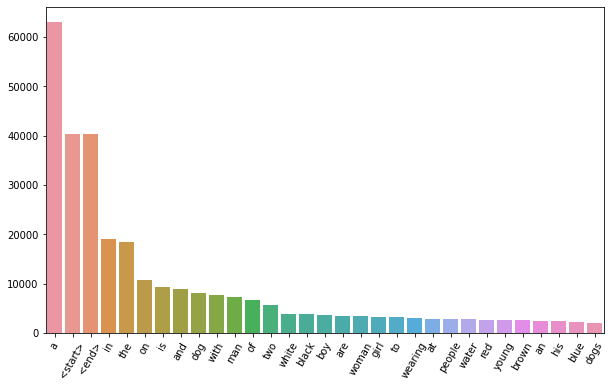

In [ ]:
# Create a word count of your tokenizer to visulize the Top 30 occuring words after text processing

get_top_words_based_on_cnt(tokenizer.word_counts,30)

In [ ]:
def min_max_for_nested_array(nested_array):
    array=[len(e) for e in nested_array]
    return min(array),max(array)

min_l, max_l = min_max_for_nested_array(train_seqs)
print(f'Max Sequence Length of the Texts is: {max_l}')

cap_vector= tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post', maxlen=max_l)
print("The shape of Caption vector is :" + str(cap_vector.shape))

Max Sequence Length of the Texts is: 39
The shape of Caption vector is :(40455, 39)


## STEP 4 : Pre-processing the images

1.Resize them into the shape of (299, 299)

3.Normalize the image within the range of -1 to 1, such that it is in correct format for InceptionV3. 

### FAQs on how to resize the images::
* Since you have a list which contains all the image path, you need to first convert them to a dataset using <i>tf.data.Dataset.from_tensor_slices</i>. Once you have created a dataset consisting of image paths, you need to apply a function to the dataset which will apply the necessary preprocessing to each image. 
* This function should resize them and also should do the necessary preprocessing that it is in correct format for InceptionV3.


In [ ]:
# Create the dataset consisting of image paths
def load_the_image(file_path):
    

In [ ]:
# Creating the function. This function should return images & their path

def load_image(image_path):
    my_img = tf.io.read_file(image_path)
    my_img = tf.image.decode_jpeg(my_img, channels=3)
    my_img = tf.image.resize(my_img, (299, 299))
    my_img = tf.keras.applications.inception_v3.preprocess_input(my_img)
    
    return my_img, image_path


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


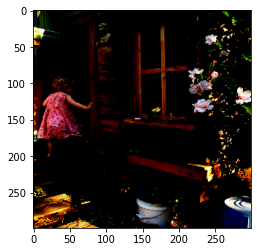

In [ ]:
plt.imshow(load_the_image(all_img_path[0])[0])

In [ ]:
#write your code here for applying the function to the image path dataset, such that the transformed dataset should contain images & their path
encode_train_set = sorted(set(all_img_vector))

feature_dict = {}

image_data_set = tf.data.Dataset.from_tensor_slices(encode_train_set)
image_data_set = image_data_set.map(load_the_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(32)

## STEP 5 :  Load the pretrained Imagenet weights of Inception net V3

1.To save the memory(RAM) from getting exhausted, extract the features of the images using the last layer of pre-trained model. Including this as part of training will lead to higher computational time.

2.The shape of the output of this layer is 8x8x2048. 

3.Use a function to extract the features of each image in the train & test dataset such that the shape of each image should be (batch_size, 8*8, 2048)



In [ ]:
image_model = tf.keras.applications.InceptionV3(include_top=False,weights='imagenet')

new_input = image_model.input 
hidden_layer = image_model.layers[-1].output 

image_features_extract_model = keras.Model(new_input, hidden_layer) 

In [ ]:
image_features_extract_model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, None, None, 3 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, None, None, 3 0           batch_normalization[0][0]        
_______________________________________________________________________________________

### FAQs on how to store the features:
* You can store the features using a dictionary with the path as the key and values as the feature extracted by the inception net v3 model OR
* You can store using numpy(np.save) to store the resulting vector.

## STEP 6 : Dataset creation
1.Apply train_test_split on both image path & captions to create the train & test list. Create the train-test spliit using 80-20 ratio & random state = 42

2.Create a function which maps the image path to their feature. 

3.Create a builder function to create train & test dataset & apply the function created earlier to transform the dataset

2.Make sure you have done Shuffle and batch while building the dataset

3.The shape of each image in the dataset after building should be (batch_size, 8*8, 2048)

4.The shape of each caption in the dataset after building should be(batch_size, max_len)


In [ ]:
path_train, path_test, cap_train, cap_test = train_test_split(all_img_vector,
                                                              cap_vector,
                                                              test_size=0.2,
                                                              random_state=33)

In [ ]:
print("Training data for images: " + str(len(path_train)))
print("Testing data for images: " + str(len(path_test)))
print("Training data for Captions: " + str(len(cap_train)))
print("Testing data for Captions: " + str(len(cap_test)))

Training data for images: 32364
Testing data for images: 8091
Training data for Captions: 32364
Testing data for Captions: 8091


In [ ]:
# Create a function which maps the image path to their feature. 
# This function will take the image_path & caption and return it's feature & respective caption.

def map_func(image_name, capt):
  
  img_tensor = feature_dict[image_name.decode('utf-8')]
  return img_tensor, capt

In [ ]:
for image, path in tqdm(image_data_set):

    batch_features = image_features_extract_model(image)
    batch_features = tf.reshape(batch_features,(batch_features.shape[0], -1, batch_features.shape[3]))
    
    for batch_f, p in zip(batch_features, path):
        path_of_feature = p.numpy().decode("utf-8")
        feature_dict[path_of_feature] =  batch_f.numpy()

100%|██████████| 253/253 [17:20<00:00,  4.11s/it]


In [ ]:
batch_f.shape

TensorShape([64, 2048])

### FAQs on how to load the features:
* You can load the features using the dictionary created earlier OR
* You can store using numpy(np.load) to load the feature vector.

In [ ]:
# create a builder function to create dataset which takes in the image path & captions as input
# This function should transform the created dataset(img_path,cap) to (features,cap) using the map_func created earlier
BATCH_SIZE = 32
BUFFER_SIZE = 1000
def gen_dataset(images_data, captions_data):
    
    dataset = tf.data.Dataset.from_tensor_slices((images_data, captions_data))
    dataset = dataset.shuffle(BUFFER_SIZE)

    dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(BATCH_SIZE)

    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    return dataset



In [ ]:
train_dataset=gen_dataset(path_train, cap_train)
test_dataset=gen_dataset(path_test, cap_test)

In [ ]:
sample_img_batch, sample_cap_batch = next(iter(train_dataset))
print(sample_img_batch.shape)  #(batch_size, 8*8, 2048)
print(sample_cap_batch.shape) #(batch_size,max_len)

(32, 64, 2048)
(32, 39)


## STEP 7 : Model Building
### 7.1 
1.Set the parameters

2.Build the Encoder, Attention model & Decoder

In [ ]:
embedding_dim = 256 
units = 512
vocab_size = 5001 #top 5,000 words +1
train_num_steps = len(path_train) // BATCH_SIZE
test_num_steps = len(path_test) // BATCH_SIZE

### 7.2 Encoder

In [ ]:
class Encoder(Model):
    def __init__(self,embed_dim):
        super(Encoder, self).__init__()
        self.dense = layers.Dense(embed_dim)
        self.dropout = layers.Dropout(0.5)
        
    def call(self, features):
        features =  self.dense(features)
        features = tf.nn.relu(features)
        return features

In [ ]:
encoder=Encoder(embedding_dim)

### 7.3 Attention model

In [ ]:
class Attention_model(Model):
    def __init__(self, units):
        super(Attention_model, self).__init__()
        self.W1 = layers.Dense(units)
        self.W2 = layers.Dense(units)
        self.V = layers.Dense(1)
        self.units=units

    def call(self, features, hidden):
        # features shape: (batch_size, 8*8, embedding_dim)
        # hidden shape: (batch_size, hidden_size)
        hidden_with_time_axis =  tf.expand_dims(hidden, 1)
        score = keras.activations.tanh(self.W1(features) + self.W2(hidden_with_time_axis))
        attention_weights =  keras.activations.softmax(self.V(score), axis=1)
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

### 7.4 Decoder

In [ ]:
class Decoder(Model):

    def __init__(self, embed_dim, units, vocab_size):
        super(Decoder, self).__init__()
        self.units=units
        self.attention = Attention_model(self.units)
        self.embedding = layers.Embedding(vocab_size, embedding_dim)
        self.gru = layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
        self.d1 = layers.Dense(self.units)
        self.d2 = layers.Dense(vocab_size)
        
    def call(self,x,features, hidden):

        context_vector, attention_weights = self.attention(features, hidden)
        embed =  self.embedding(x)
        embed =  tf.concat([tf.expand_dims(context_vector, 1), embed], axis=-1)
        output, state = self.gru(embed)
        output = self.d1(output)
        output = tf.reshape(output, (-1, output.shape[2])) # shape : (batch_size * max_length, hidden_size)
        output = self.d2(output) # shape : (batch_size * max_length, vocab_size)
        
        return output, state, attention_weights
    
    def init_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [ ]:
decoder=Decoder(embedding_dim, units, vocab_size)

In [ ]:
features=encoder(sample_img_batch)

hidden = decoder.init_state(batch_size=sample_cap_batch.shape[0])
dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * sample_cap_batch.shape[0], 1)

predictions, hidden_out, attention_weights= decoder(dec_input, features, hidden)
print('Feature shape from Encoder: {}'.format(features.shape)) 
print('Predcitions shape from Decoder: {}'.format(predictions.shape)) 
print('Attention weights shape from Decoder: {}'.format(attention_weights.shape)) 

Feature shape from Encoder: (32, 64, 256)
Predcitions shape from Decoder: (32, 5001)
Attention weights shape from Decoder: (32, 64, 1)


## STEP 8 : Model training & optimization
1.Set the optimizer & loss object

2.Create your checkpoint path

3.Create your training & testing step functions

4.Create your loss function for the test dataset

In [ ]:
optimizer = keras.optimizers.Adam()
loss_object = keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

In [ ]:
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [ ]:
checkpoint_path = os.path.join("checkpoints", "train")
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [ ]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])

* While creating the training step for your model, you will apply Teacher forcing.
* Teacher forcing is a technique where the target/real word is passed as the next input to the decoder instead of previous prediciton.

In [ ]:
@tf.function
def train_step(img_tensor, target):
    loss = 0

    hidden = decoder.init_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

    with tf.GradientTape() as tape:
        features = encoder(img_tensor)

        for i in range(1, target.shape[1]):
            predictions, hidden, _ = decoder(dec_input, features, hidden)
            loss += loss_function(target[:, i], predictions)
            dec_input = tf.expand_dims(target[:, i], 1)

        avg_loss = (loss/int(target.shape[1]))
        trainable_variables = encoder.trainable_variables + decoder.trainable_variables
        gradients = tape.gradient(loss, trainable_variables)
        optimizer.apply_gradients(zip(gradients, trainable_variables))
        
        return loss, avg_loss

* While creating the test step for your model, you will pass your previous prediciton as the next input to the decoder.

In [ ]:
@tf.function
def test_step(img_tensor, target):
    loss = 0
    hidden = decoder.init_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

    with tf.GradientTape() as tape:
        features = encoder(img_tensor)

        for i in range(1, target.shape[1]):
            predictions, hidden, _ = decoder(dec_input, features, hidden)
            loss += loss_function(target[:, i], predictions)
            dec_input = tf.expand_dims(target[:, i], 1)

        avg_loss = (loss / int(target.shape[1]))

        trainable_variables = encoder.trainable_variables + decoder.trainable_variables
        gradients = tape.gradient(loss, trainable_variables)
        optimizer.apply_gradients(zip(gradients, trainable_variables))

        return loss, avg_loss

In [ ]:
def test_loss_cal(test_dataset):
    total_loss = 0
    
    for (batch, (img_tensor, target)) in enumerate(test_dataset):
        batch_loss, t_loss = test_step(img_tensor, target)
        total_loss += t_loss

    avg_test_loss = total_loss/test_num_steps

    return avg_test_loss

In [ ]:
loss_plot = []
test_loss_plot = []
EPOCHS = 15

best_test_loss=100
for epoch in tqdm(range(0, EPOCHS)):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(train_dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss
        avg_train_loss=total_loss / train_num_steps
        
    loss_plot.append(avg_train_loss)    
    test_loss = test_loss_cal(test_dataset)
    test_loss_plot.append(test_loss)
    
    print ('For epoch: {}, the train loss is {:.3f}, & test loss is {:.3f}'.format(epoch+1, avg_train_loss, test_loss))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))
    
    if test_loss < best_test_loss:
        print('Test loss has been reduced from %.3f to %.3f' % (best_test_loss, test_loss))
        best_test_loss = test_loss
        ckpt_manager.save()

  0%|          | 0/15 [00:00<?, ?it/s]

For epoch: 1, the train loss is 1.202, & test loss is 1.006
Time taken for 1 epoch 2303.27739238739 sec

Test loss has been reduced from 100.000 to 1.006


  7%|▋         | 1/15 [38:23<8:57:31, 2303.69s/it]

For epoch: 2, the train loss is 0.943, & test loss is 0.891
Time taken for 1 epoch 2187.5313074588776 sec

Test loss has been reduced from 1.006 to 0.891


 13%|█▎        | 2/15 [1:14:51<8:04:24, 2235.70s/it]

For epoch: 3, the train loss is 0.857, & test loss is 0.822
Time taken for 1 epoch 2091.889070749283 sec

Test loss has been reduced from 0.891 to 0.822


 20%|██        | 3/15 [1:49:44<7:14:03, 2170.30s/it]

For epoch: 4, the train loss is 0.795, & test loss is 0.766
Time taken for 1 epoch 2113.2610416412354 sec

Test loss has been reduced from 0.822 to 0.766


 27%|██▋       | 4/15 [2:24:57<6:33:47, 2147.96s/it]

For epoch: 5, the train loss is 0.744, & test loss is 0.720
Time taken for 1 epoch 2033.4761879444122 sec

Test loss has been reduced from 0.766 to 0.720


 33%|███▎      | 5/15 [2:58:51<5:51:08, 2106.84s/it]

For epoch: 6, the train loss is 0.701, & test loss is 0.678
Time taken for 1 epoch 2240.762545108795 sec

Test loss has been reduced from 0.720 to 0.678


 40%|████      | 6/15 [3:36:13<5:22:52, 2152.55s/it]

For epoch: 7, the train loss is 0.660, & test loss is 0.641
Time taken for 1 epoch 2108.688460826874 sec

Test loss has been reduced from 0.678 to 0.641


 47%|████▋     | 7/15 [4:11:22<4:45:07, 2138.38s/it]

For epoch: 8, the train loss is 0.624, & test loss is 0.605
Time taken for 1 epoch 2049.6408734321594 sec

Test loss has been reduced from 0.641 to 0.605


 53%|█████▎    | 8/15 [4:45:32<4:06:12, 2110.29s/it]

For epoch: 9, the train loss is 0.591, & test loss is 0.574
Time taken for 1 epoch 2028.765732049942 sec

Test loss has been reduced from 0.605 to 0.574


 60%|██████    | 9/15 [5:19:21<3:28:29, 2084.98s/it]

For epoch: 10, the train loss is 0.561, & test loss is 0.544
Time taken for 1 epoch 1995.9884848594666 sec

Test loss has been reduced from 0.574 to 0.544


 67%|██████▋   | 10/15 [5:52:38<2:51:28, 2057.66s/it]

For epoch: 11, the train loss is 0.533, & test loss is 0.520
Time taken for 1 epoch 1950.5252118110657 sec

Test loss has been reduced from 0.544 to 0.520


 73%|███████▎  | 11/15 [6:25:09<2:15:00, 2025.03s/it]

For epoch: 12, the train loss is 0.509, & test loss is 0.492
Time taken for 1 epoch 1980.8171229362488 sec

Test loss has been reduced from 0.520 to 0.492


 80%|████████  | 12/15 [6:58:10<1:40:35, 2011.74s/it]

For epoch: 13, the train loss is 0.486, & test loss is 0.469
Time taken for 1 epoch 1991.2269377708435 sec

Test loss has been reduced from 0.492 to 0.469


 87%|████████▋ | 13/15 [7:31:22<1:06:51, 2005.68s/it]

For epoch: 14, the train loss is 0.465, & test loss is 0.452
Time taken for 1 epoch 1955.776745557785 sec

Test loss has been reduced from 0.469 to 0.452


 93%|█████████▎| 14/15 [8:03:58<33:10, 1990.75s/it]  

For epoch: 15, the train loss is 0.446, & test loss is 0.432
Time taken for 1 epoch 2008.785745382309 sec

Test loss has been reduced from 0.452 to 0.432


100%|██████████| 15/15 [8:37:28<00:00, 2069.87s/it]


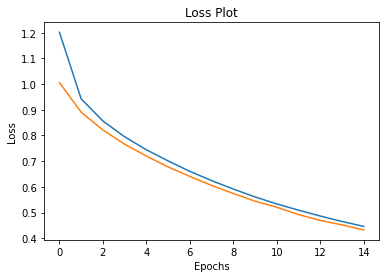

In [ ]:
plt.plot(loss_plot)
plt.plot(test_loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

#### NOTE: 
* Since there is a difference between the train & test steps ( Presence of teacher forcing), you may observe that the train loss is decreasing while your test loss is not. 
* This doesn't mean that the model is overfitting, as we can't compare the train & test results here, as both approach is different.
* Also, if you want to achieve better results you can run it more epochs, but the intent of this capstone is to give you an idea on how to integrate attention mechanism with E-D architecture for images. The intent is not to create the state of art model. 

## STEP 9 : Model Evaluation
1.Define your evaluation function using greedy search

2.Define your evaluation function using beam search ( optional)

3.Test it on a sample data using BLEU score

### 9.1 : Greedy Search

In [ ]:
def evaluate(image):
    max_length=max_l
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.init_state(batch_size=1)

    temp_input = tf.expand_dims(load_the_image(image)[0], 0) # process the input image to desired format before extracting features
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot,predictions

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]

    return result, attention_plot,predictions

### 9.2 : Beam Search(optional)

In [ ]:
def beam_evaluate(image, beam_index = 3):
    max_length=max_l
    start = [tokenizer.word_index['<start>']]
    result = [[start, 0.0]]

    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.init_state(batch_size=1)

    temp_input = tf.expand_dims(load_the_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)

    while len(result[0][0]) < max_length:
        i=0
        temp = []
        for s in result:
            predictions, hidden, attention_weights = decoder(dec_input, features, hidden)
            attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()
            i=i+1
            word_preds = np.argsort(predictions[0])[-beam_index:]
          
            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
            
                prob += np.log(predictions[0][w])
                    
                temp.append([next_cap, prob])
        result = temp
        result = sorted(result, reverse=False, key=lambda l: l[1])
        result = result[-beam_index:]
        
        
        predicted_id = result[-1]
        pred_list = predicted_id[0]
        
        prd_id = pred_list[-1] 
        if(prd_id!=3):
            dec_input = tf.expand_dims([prd_id], 0)  
        else:
            break
    
    
    result2 = result[-1][0]
    
    intermediate_caption = [tokenizer.index_word[i] for i in result2]
    final_caption = []
    for i in intermediate_caption:
        if i != '<end>':
            final_caption.append(i)
            
        else:
            break

    attention_plot = attention_plot[:len(result), :]
    final_caption = ' '.join(final_caption[1:])
    
    return final_caption

In [ ]:
def plot_attmap(caption, weights, image):

    fig = plt.figure(figsize=(10, 10))
    temp_img = np.array(Image.open(image))
    
    len_cap = len(caption)
    for cap in range(len_cap):
        weights_img = np.reshape(weights[cap], (8,8))
        weights_img = np.array(Image.fromarray(weights_img).resize((224, 224), Image.LANCZOS))
        
        ax = fig.add_subplot(len_cap//2, len_cap//2, cap+1)
        ax.set_title(caption[cap], fontsize=15)
        
        img=ax.imshow(temp_img)
        
        ax.imshow(weights_img, cmap='gist_heat', alpha=0.6,extent=img.get_extent())
        ax.axis('off')
    plt.subplots_adjust(hspace=0.2, wspace=0.2)
    plt.show()

In [ ]:
from nltk.translate.bleu_score import sentence_bleu

In [ ]:
def filt_text(text):

    filt=['<start>','<unk>','<end>'] 
    temp= text.split()
    [temp.remove(j) for k in filt for j in temp if k==j]
    text=' '.join(temp)
    
    return text

2788
BELU score: 1.1200407237786664e-229
Real Caption: people on skateboards racing around a track
Prediction Caption: four people are jumping in the background


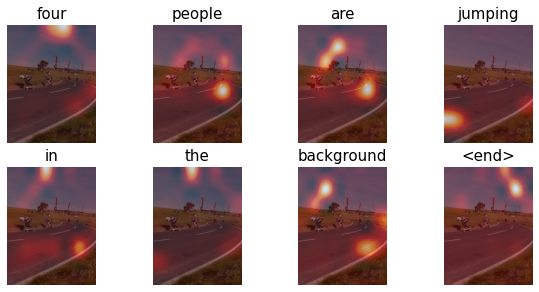

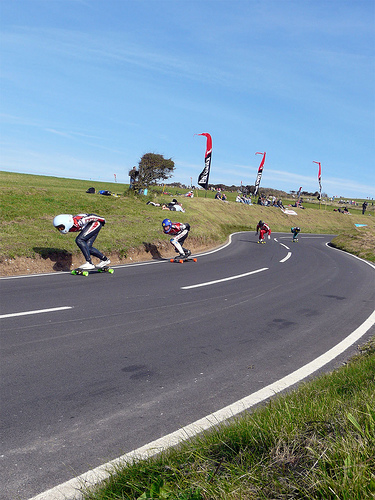

In [ ]:
features_shape = batch_f.shape[1]
attention_features_shape = batch_f.shape[0]

rid = np.random.randint(0, len(path_test))
print(rid)
test_image = path_test[rid]

real_caption = ' '.join([tokenizer.index_word[i] for i in cap_test[rid] if i not in [0]])
result, attention_plot,pred_test = evaluate(test_image)


real_caption=filt_text(real_caption)      


pred_caption=' '.join(result).rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = pred_caption.split()

score = sentence_bleu(reference, candidate, weights=(0.25, 0.25, 0.25, 0.25))
print(f"BELU score: {score*100}")

print('Real Caption:', real_caption)
print('Prediction Caption:', pred_caption)
plot_attmap(result, attention_plot, test_image)


Image.open(test_image)

In [ ]:
captions=beam_evaluate(test_image)
print(captions)

four people


In [ ]:
! pip install gTTS

Defaulting to user installation because normal site-packages is not writeable

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [ ]:
# Import the required module for text to speech conversion
from gtts import gTTS

# Language in which you want to convert
language = 'en'
  
# Passing the text and language to the engine, 
myobj = gTTS(text=pred_caption, lang=language, slow=False)
  
# Saving the converted audio in a mp3 file named
myobj.save("Predicted_text.mp3")
  
# Playing the converted file
os.system("./Predicted_text.mp3")

1